In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# loading raw dataset
df = pd.read_csv("../data/raw/Telco_customer_churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
df["CustomerID"].duplicated().sum()

np.int64(0)

In [4]:
# inspecting dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df["Total Charges"].unique()

array([ 108.15,  151.65,  820.5 , ..., 7362.9 ,  346.45, 6844.5 ],
      shape=(6531,))

In [6]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [7]:
df["Multiple Lines"].replace({"No phone service": "No"}, inplace=True )
cols = [
    "Online Security",
    "Online Backup",
    "Device Protection",
    "Tech Support",
    "Streaming TV",
    "Streaming Movies"
]

df[cols] = df[cols].replace({"No internet service": "No"})

C:\Users\USER\AppData\Local\Temp\ipykernel_9476\1246895604.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Multiple Lines"].replace({"No phone service": "No"}, inplace=True )


In [8]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    if (df[col] < 0).any():
        print(f"Negative values found in {col}")

Negative values found in Longitude


In [9]:
# dropping customer with zero tenure in months, because this is highly unlikely
df = df[df["Tenure Months"] > 0]

In [10]:
df["Calculated Total"] = round((df["Monthly Charges"] * df["Tenure Months"]), 2)

df["Revenue Difference"] = round((abs(df["Total Charges"] - df["Calculated Total"])), 2)

df["Revenue Difference"].describe()

count    7032.000000
mean       45.089157
std        49.899711
min         0.000000
25%         9.437500
50%        28.650000
75%        63.700000
max       373.250000
Name: Revenue Difference, dtype: float64

In [11]:
# managing logical in consisitency in total revenue
Q1 = df["Revenue Difference"].quantile(0.25)
Q3 = df["Revenue Difference"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = round((Q3 + 1.5 * IQR), 0)
upper_bound

np.float64(145.0)

In [12]:
df[df["Revenue Difference"] > 145].shape

(365, 35)

In [13]:
df.groupby("Contract")["Tenure Months"].describe()

,count,mean,std,min,25%,50%,75%,max
Contract,,,,,,,,
Month-to-month,3875.0,18.036645,17.689054,1.0,3.0,12.0,29.0,72.0
One year,1472.0,42.073370,19.010750,1.0,27.0,44.0,58.0,72.0
Two year,1685.0,57.071810,17.729130,1.0,48.0,64.0,71.0,72.0


In [14]:
# checking for outliers in "Total Revenue"
num_cols = df[["Total Charges"]]
q1 = num_cols.quantile(0.25)
q3 = num_cols.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = ((num_cols < lower_bound) | (num_cols > upper_bound))
outliers.sum()

Total Charges    0
dtype: int64

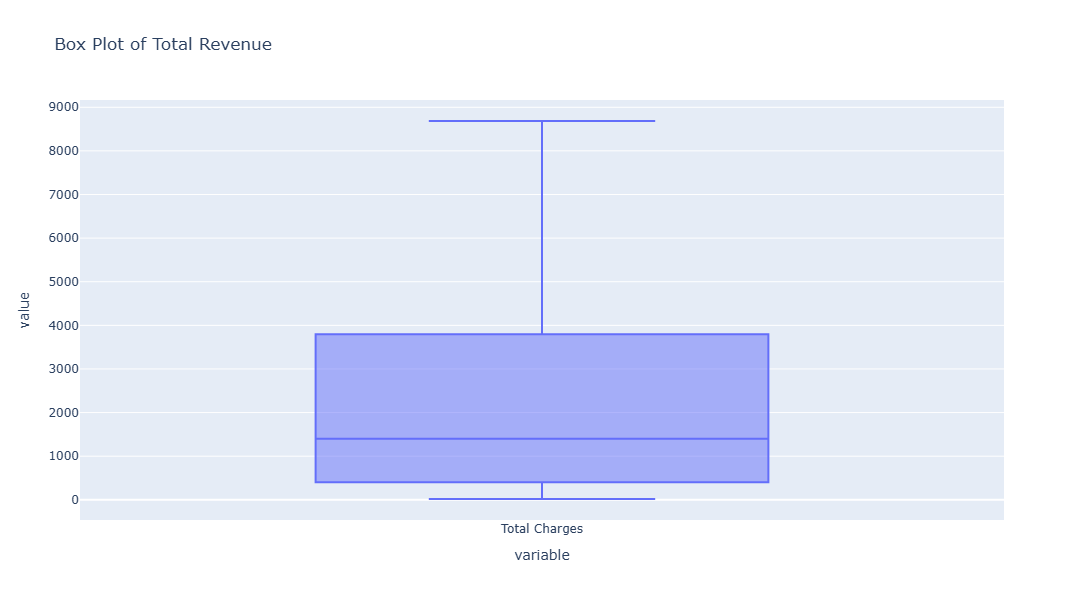

In [15]:
# using boxplot to visualize oulier for the "Total Revenue" feature
fig = px.box(
    df,
    y=["Total Charges"],
    title="Box Plot of Total Revenue ",
    width=600,
    height=600
    # yaxis_title= "Numerical Features",
    # vert=False
)
fig.show()

In [16]:
unreq_features = {
    "State",
    "Zip Code",
    "Count",
    "Country",
    "Lat Long",
    "Latitude",
    "Longitude",
    "CLTV",
    "Churn Label",
    "Churn Score"
    # "Churn Reason"
}

df.drop(columns=unreq_features, inplace=True)

In [17]:
df.isnull().sum()

CustomerID               0
City                     0
Gender                   0
Senior Citizen           0
Partner                  0
Dependents               0
Tenure Months            0
Phone Service            0
Multiple Lines           0
Internet Service         0
Online Security          0
Online Backup            0
Device Protection        0
Tech Support             0
Streaming TV             0
Streaming Movies         0
Contract                 0
Paperless Billing        0
Payment Method           0
Monthly Charges          0
Total Charges            0
Churn Value              0
Churn Reason          5163
Calculated Total         0
Revenue Difference       0
dtype: int64

In [18]:
df.to_csv("../data/cleaned/cleaned_telco_customer_churn.csv", index=False)